In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

In [5]:
from sklearn.mixture import GaussianMixture

# CLUSTERING

## Importing the Data
Upon importing the data, houses and condomenium properties are separated since based on the EDA, both have different ranges of prices and total developed. Combining them will not benefit the overall result of the cluster.

In [6]:
df = pd.read_json('cleaned_data.json')
condo_df = df[df['Type'] == 'Condo']
house_df = df[df['Type'] == 'House']
df.head()

,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Features,...,Nearby Places,URL,Timestamp,City,Region,Island,Type,NFeatures,NFacilities,NNearby Places
0,"3 BR Condo in The Grand Midori Ortigas, Pasig",,"Federal Land, Inc.",29700000,3,3.0,2,0,107.0,"[Ensuite, Range Hood, Stove/Burner]",...,"[School, Hospital]",https://propertyaccess.ph/property/3-br-condo-...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,3,11,2
1,"1 Bedroom Condo in The Grand Midori Ortigas, P...",,"Federal Land, Inc.",10200000,1,1.0,0,0,46.0,[Fiber ready],...,"[School, Hospital]",https://propertyaccess.ph/property/1br-condo-i...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,1,11,2
2,"3 Bedroom Condo in Aurelia Residences, Taguig","McKinley Parkway, Taguig, Metro Manila",Shang Properties,107300000,3,4.0,2,0,242.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23,Taguig,National Capital Region,Luzon,Condo,10,15,4
3,3 Bedroom Condo in Shang Residences at Wack Wa...,"Wack Wack Road, Mandaluyong, Metro Manila",Shang Properties,54500000,3,4.0,3,0,231.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23,Mandaluyong,National Capital Region,Luzon,Condo,9,16,4
4,"2BR Condo in Residences at The Galleon, Pasig",,Ortigas Land,41500000,2,2.0,2,0,109.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/2br-condo-i...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,7,14,4


In [7]:
# data to be used for clustering
data = df[['Price', 'Bedrooms', 'Showers', 'Parking', 'Total Developed']]
condo_data = condo_df[['Price', 'Bedrooms', 'Showers', 'Parking', 'Total Developed']]
house_data = house_df[['Price', 'Bedrooms', 'Showers', 'Parking', 'Total Developed']]

## K Means Clustering

## Gaussian 

### Condos

#### Getting appropriate number of clusters
To get this, the elbow method will be utilized, however the values that will be used would be the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) scores of each components.

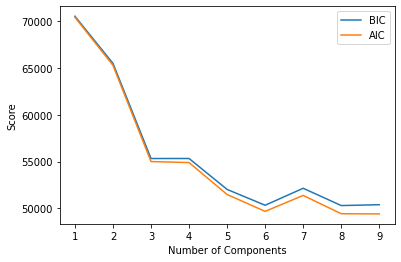

In [130]:
# check AIC and BIC as a function of number of components
N = np.arange(1,10)
models = [GaussianMixture(n,covariance_type='full',
          random_state=0).fit(condo_data) for n in N]
plt.plot(N, [m.bic(condo_data) for m in models], label='BIC')
plt.plot(N, [m.aic(condo_data) for m in models], label='AIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Score');

Both AIC, and BIC values shows us the **6** is the best value for n_components.

#### Defining the Model

<Figure size 864x576 with 0 Axes>

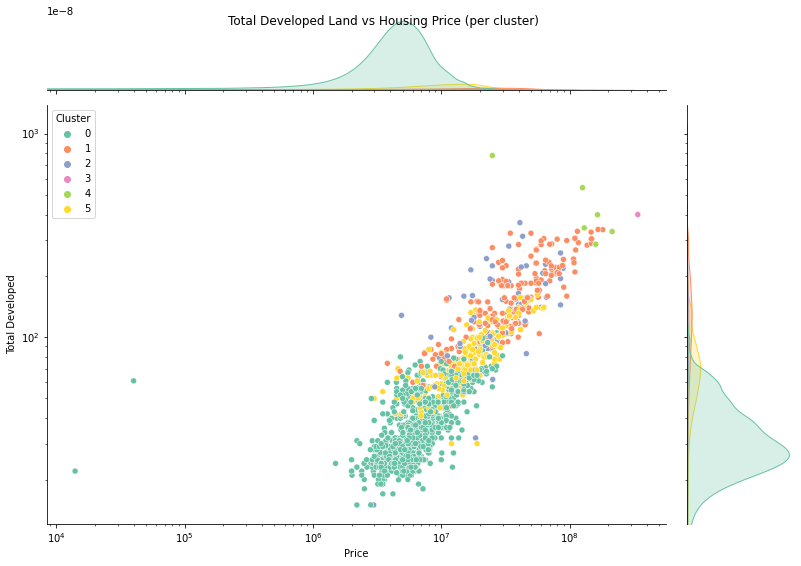

In [131]:
# define the model
model = GaussianMixture(n_components=6, covariance_type='full', random_state=0).fit(condo_data)
# assign a cluster to each example
yhat = model.predict(condo_data)

gaussianDF = condo_df.copy()

gaussianDF['Cluster'] = yhat

_ = plt.figure(figsize=(12, 8))

g = sns.jointplot(data=gaussianDF, x="Price", y="Total Developed", hue="Cluster", palette='Set2')

g.fig.suptitle("Total Developed Land vs Housing Price (per cluster)")
g.fig.set_size_inches((12, 8)) 
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

By looking at the chart, we can see the relationship of the different clusters from one another based on their Total Area (in sqm) vs the Selling price of the properties within those clusters.

#### Results per Cluster
##### Number of Items per Cluster

Text(0, 0.5, 'Count')

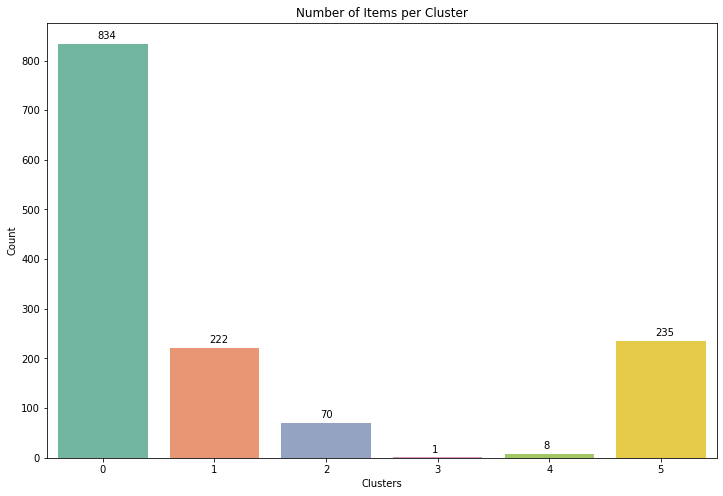

In [97]:
_ = plt.figure(figsize=(12, 8))

g = sns.countplot(x='Cluster', data=gaussianDF, palette='Set2')
for p in g.patches:
    g.annotate('{}'.format(p.get_height()), (p.get_x()+.35, p.get_height()+10))

plt.title("Number of Items per Cluster")
plt.xlabel("Clusters")
plt.ylabel("Count")

Cluster 0 has the most items, followed by 4, 1, 3, and 2.

##### Total Developed vs Price per Cluster

Text(0.5, 1.0, 'Prices per Cluster')

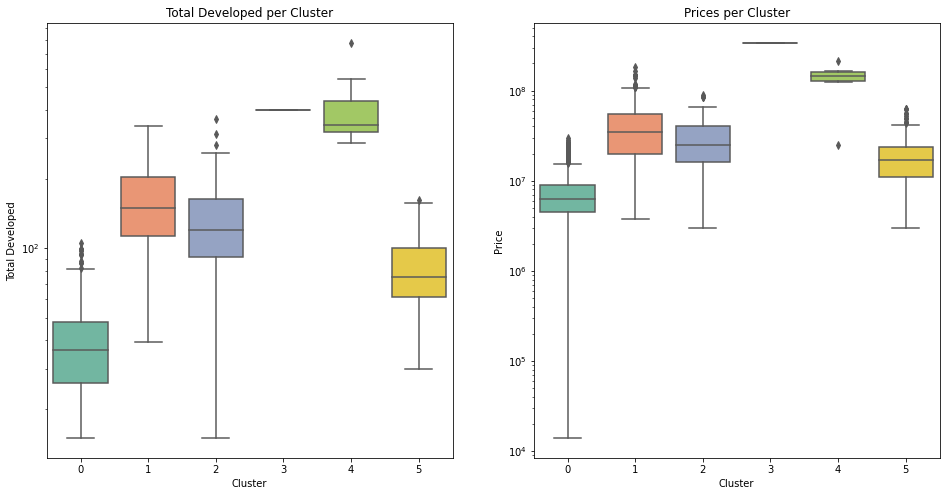

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=gaussianDF, x='Cluster', y='Total Developed', palette='Set2', ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title("Total Developed per Cluster")

sns.boxplot(data=gaussianDF, x='Cluster', y='Price', palette='Set2', ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title("Prices per Cluster")

By comparing the clusters through their boxplots, we can see the price and area ranges of each cluster. We can see that:
1. Cluster 0 - has the lowest prices and total developed area _(low-end condomeniums)_
2. Cluster 1 - has middle prices and total developed area but a little higher  _(higher mid-end condomeniums)_
6. Cluster 2 - has middle prices and total developed area but a little bit lower _(lower mid-end condomeniums)_
3. Cluster 3 - has the highest price and but only as same total developed area with Cluster 3 _(outlier)_
4. Cluster 4 - has the highest prices and total developed overall _(high-end condomeniums)_
5. Cluster 5 - has second lowest prices and total developed area _(low to mid-end condomeniums)_

##### Total Bedrooms vs Showers

Text(0.5, 1.0, 'Showers per Cluster')

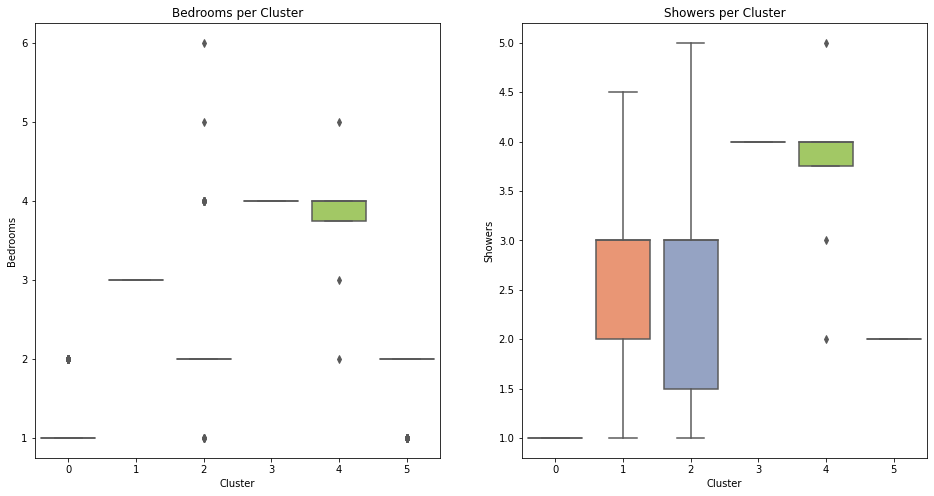

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=gaussianDF, x='Cluster', y='Bedrooms', palette='Set2', ax=ax[0])
ax[0].set_title("Bedrooms per Cluster")

sns.boxplot(data=gaussianDF, x='Cluster', y='Showers', palette='Set2', ax=ax[1])
ax[1].set_title("Showers per Cluster")

By looking at the amount of bedrooms and showers of properties in each cluster, we can see that:
1. **Low-end** condomeniums typically only has _1 bedroom with 1 shower_
2. The **Higher Mid-end** condomeniums typically have _3 bedrooms with 2-3 showers_.
3. The **Lower Mid-end** condomeniums typically have _2 bedrooms with 1-3 showers_.
4. The **outlier** had _4 bedrooms and showers_.
5. The **High-end** condomeniums typically have _4 bedrooms and showers_.
6. The **Low to Mid-end** condomeniums typically have _2 bedrooms and showers_.

##### Most Common Location per Cluster

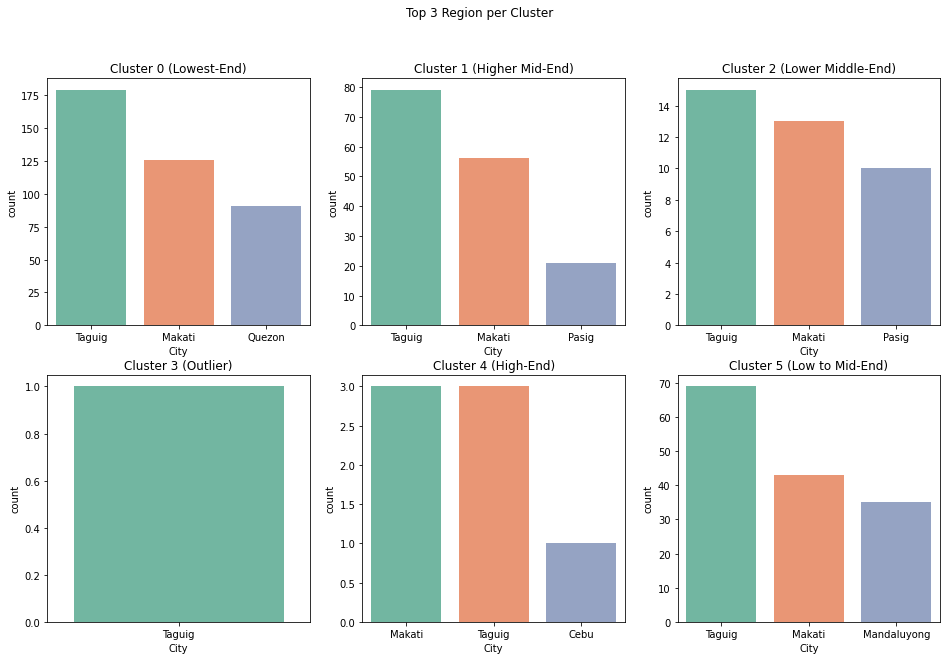

In [134]:
descriptions = ['Lowest-End', 'Higher Mid-End', 'Lower Middle-End', 'Outlier', 'High-End', 'Low to Mid-End']

fig = plt.figure(figsize=(16, 10))

fig.suptitle('Top 3 City per Cluster')

for cluster in range(6):
    fig.add_subplot(2, 3, cluster + 1)
    g = sns.countplot(x='City', data=gaussianDF[gaussianDF['Cluster'] == cluster], order=gaussianDF[gaussianDF['Cluster'] == cluster]['City'].value_counts().iloc[:3].index, palette="Set2")
    
    plt.title("Cluster %d (%s)" % (cluster, descriptions[cluster]))

We can see that the **Taguig** is the region with the **most the number of condomeniums listed for all clusters**. Along with Makati, Pasig, Quezon, Mandaluyong, and Cebu.

### Houses

#### Getting appropriate number of clusters
To get this, the elbow method will be utilized, however the values that will be used would be the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) scores of each components.

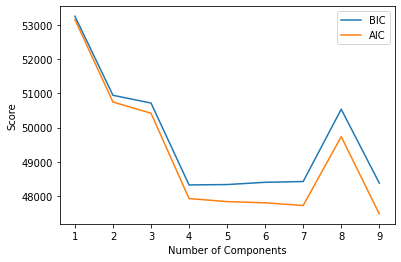

In [135]:
# check AIC and BIC as a function of number of components
N = np.arange(1, 10)
models = [GaussianMixture(n ,covariance_type='full',
          random_state=0).fit(house_data) for n in N]
plt.plot(N, [m.bic(house_data) for m in models], label='BIC')
plt.plot(N, [m.aic(house_data) for m in models], label='AIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Score');

Both AIC, and BIC values shows us the **4** is the best value for n_components.

#### Defining the Model

<Figure size 864x576 with 0 Axes>

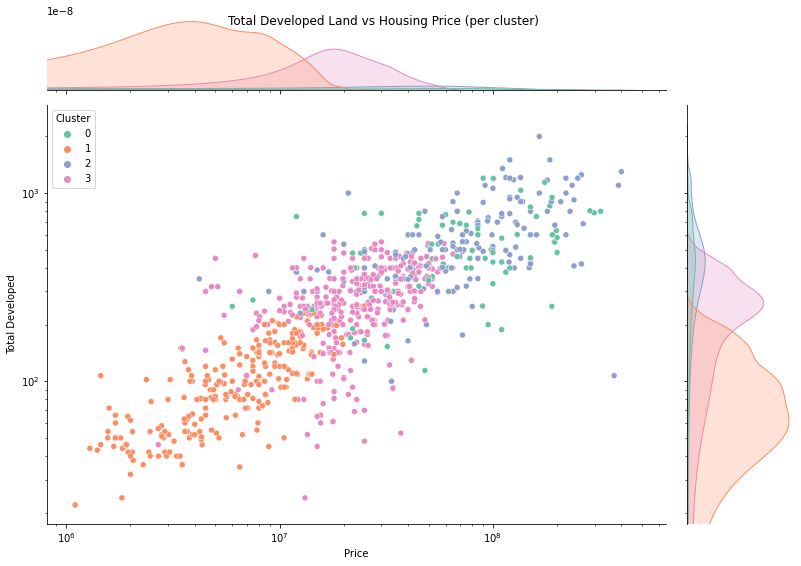

In [136]:
# define the model
model = GaussianMixture(n_components=4, covariance_type='full', random_state=0).fit(house_data)
# assign a cluster to each example
yhat = model.predict(house_data)

gaussianDF = house_df.copy()

gaussianDF['Cluster'] = yhat

_ = plt.figure(figsize=(12, 8))

g = sns.jointplot(data=gaussianDF, x="Price", y="Total Developed", hue="Cluster", palette='Set2')

g.fig.suptitle("Total Developed Land vs Housing Price (per cluster)")
g.fig.set_size_inches((12, 8)) 
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

By looking at the chart, we can once again see the relationship of the different clusters from one another based on their Total Area (in sqm) vs the Selling price of the properties within those clusters. However, Cluster 1 and Cluster 3 seems a bit similar.

#### Results per Cluster
##### Number of Items per Cluster

Text(0, 0.5, 'Count')

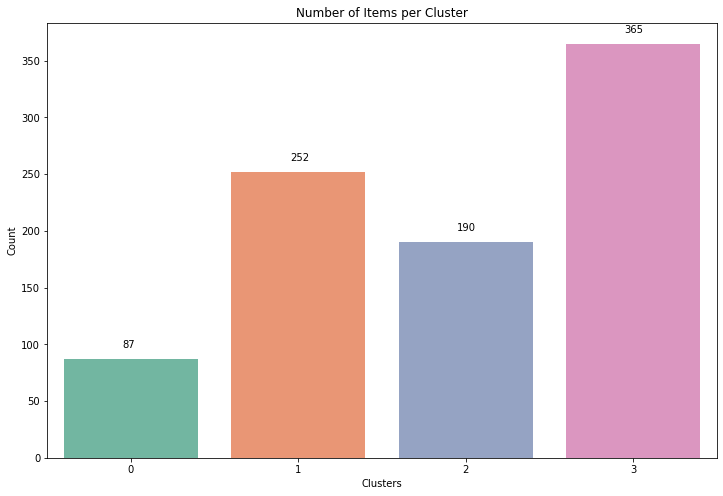

In [137]:
_ = plt.figure(figsize=(12, 8))

g = sns.countplot(x='Cluster', data=gaussianDF, palette='Set2')
for p in g.patches:
    g.annotate('{}'.format(p.get_height()), (p.get_x()+.35, p.get_height()+10))

plt.title("Number of Items per Cluster")
plt.xlabel("Clusters")
plt.ylabel("Count")

Unlike the condomeniums, houses has most properties at the Middle-end clusters (cluster 3). However, cluster 1 had the second most properties followed by cluster 2 then 0.

##### Total Developed vs Price per Cluster

Text(0.5, 1.0, 'Prices per Cluster')

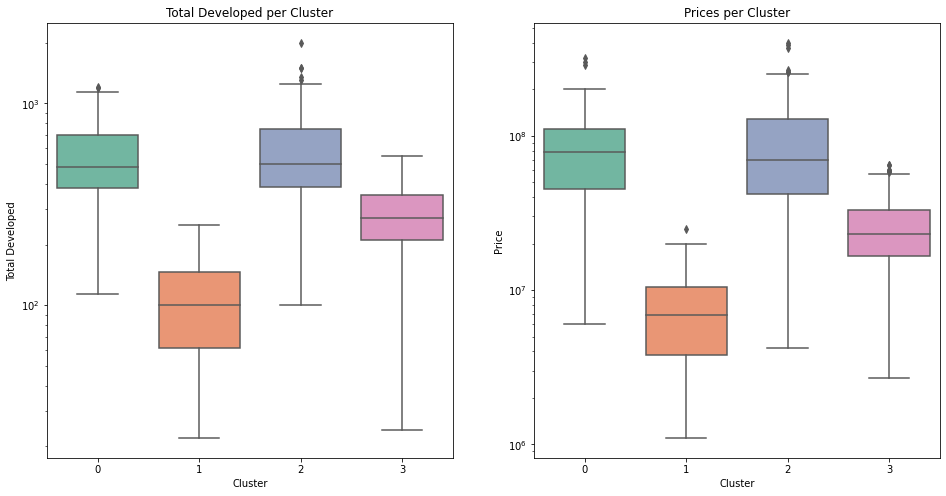

In [138]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=gaussianDF, x='Cluster', y='Total Developed', palette='Set2', ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title("Total Developed per Cluster")

sns.boxplot(data=gaussianDF, x='Cluster', y='Price', palette='Set2', ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title("Prices per Cluster")

By comparing the clusters through their boxplots, we can see the price and area ranges of each cluster. We can see that:
1. Cluster 0 - has the highest prices and total developed along with cluster 2 _(high-end houses)_
2. Cluster 1 - has lowest prices and total developed area  _(low-end houses)_
6. Cluster 2 - has the highest prices and total developed along with cluster 0 _(high-end houses)_
3. Cluster 3 - has the middle price and total developed area _(mid-end houses)_  

Since Cluster 0, and 2 are almost the same, they were assigned to the same class (high-end houses).

##### Total Bedrooms vs Showers

Text(0.5, 1.0, 'Total Showers per Cluster')

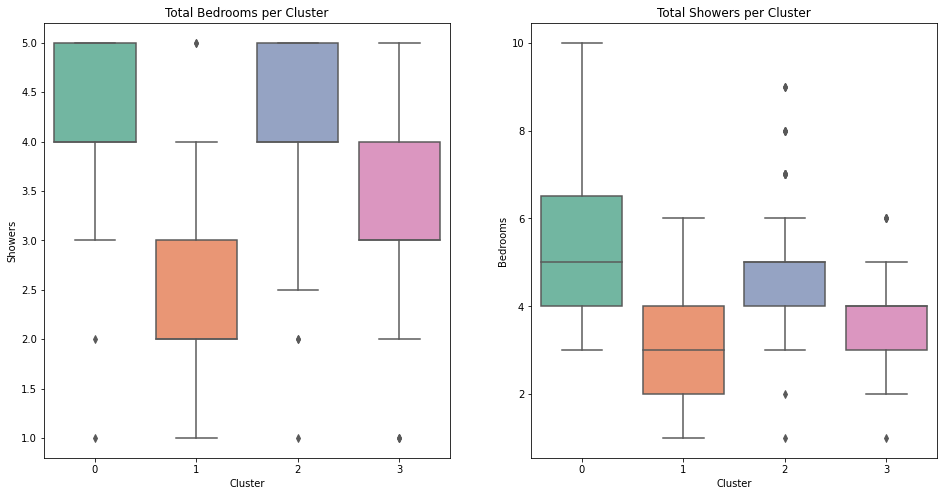

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=gaussianDF, x='Cluster', y='Bedrooms', palette='Set2', ax=ax[1])
ax[0].set_title("Total Bedrooms per Cluster")

sns.boxplot(data=gaussianDF, x='Cluster', y='Showers', palette='Set2', ax=ax[0])
ax[1].set_title("Total Showers per Cluster")

By looking at the amount of bedrooms and showers of properties in each cluster, we can see that:
1. **High-end** houses typically only has _4-5 bedroom with 4 to more shower_
2. The **Low-end** houses typically have _2-3 bedrooms with 2-4 showers_.
3. The **High-end** houses typically have _4-5 bedrooms and showers_.
6. The **Mid-end** houses typically have _3-4 bedrooms and showers_.

##### Most Common Location per Cluster

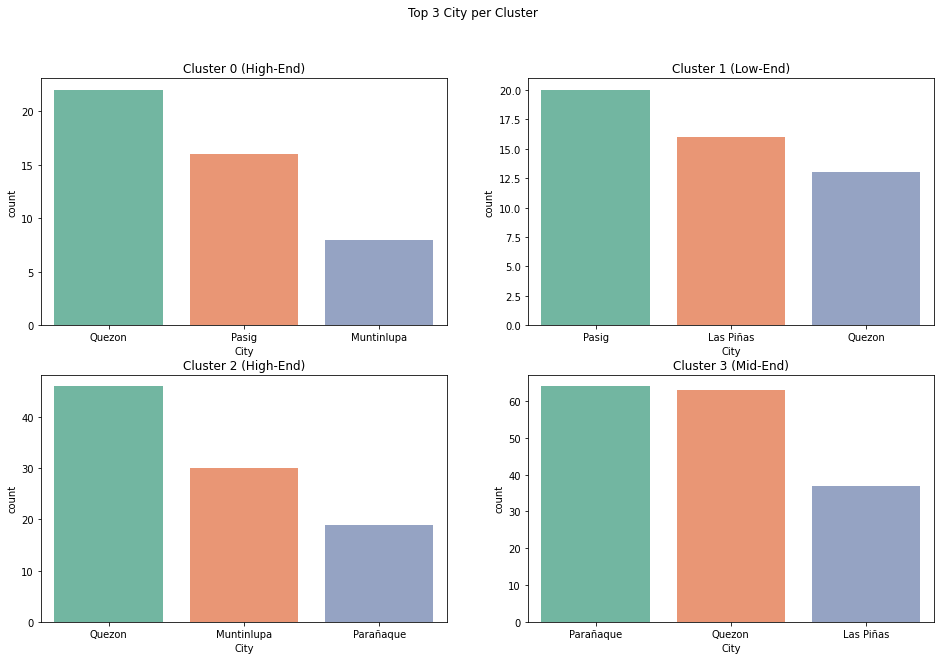

In [142]:
descriptions = ['High-End', 'Low-End', 'High-End', 'Mid-End']

fig = plt.figure(figsize=(16, 10))

fig.suptitle('Top 3 City per Cluster')

for cluster in range(4):
    fig.add_subplot(2, 2, cluster + 1)
    g = sns.countplot(x='City', data=gaussianDF[gaussianDF['Cluster'] == cluster], order=gaussianDF[gaussianDF['Cluster'] == cluster]['City'].value_counts().iloc[:3].index, palette="Set2")
    
    plt.title("Cluster %d (%s)" % (cluster, descriptions[cluster]))

For House properties, there are most high-end houses in quezon city, followed by Muntinlupa, Paranaque, and then Pasig. There are most mid-end houses in Paranaque, followed by Question, and then Las Pinas. Finally, there are most Low-End houses in Pasig, followed by Las Pinas, and then Quezon. 

### Overall Findings
- The condomenium properties were best separated into **6** clusters. While house properties were best separated into **4**.
- The different clusters **provides a good categorization of how good, and how bad each properties were** are based on the number of shower, bedrooms, and parking spaces along with the price and total developed.
- Houses generally have more bedrooms and showers than condomeniums for each cluster


- The city with most properties in each cluster for condomenium properties was Taguig.
- The cities with most properties for each clusters in house properties were spread to different locations. **High-end houses had Quezon as the top city**, **Mid-end houses had Paranaque as the to city**, and **Low-end houses had Pasig as the top city**.

# RESEARCH QUESTION

## What are the features with the highest correlation to price?

In [5]:
df = pd.read_json('cleaned_data.json', orient='columns')

Text(0.5, 1.0, 'Heatmap of Correlation between Features')

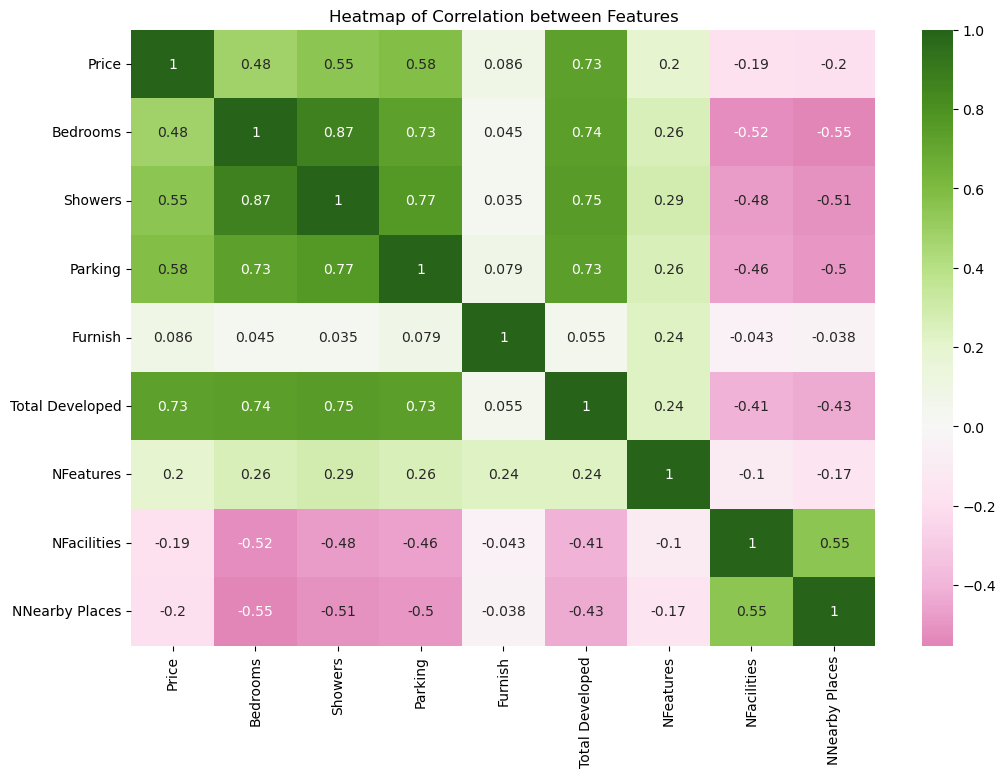

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, center=0, cmap='PiYG')
plt.title('Heatmap of Correlation between Features')

Results of heatmap - Highest correlation to price:  
   
    Top 1:    Parking
    
    Top 2/3:  Showers / Total Developed

### To further analyze the correlation between price and parking, showers, and total developed, we utilized pairplots to see the relationships between features in the heatmap


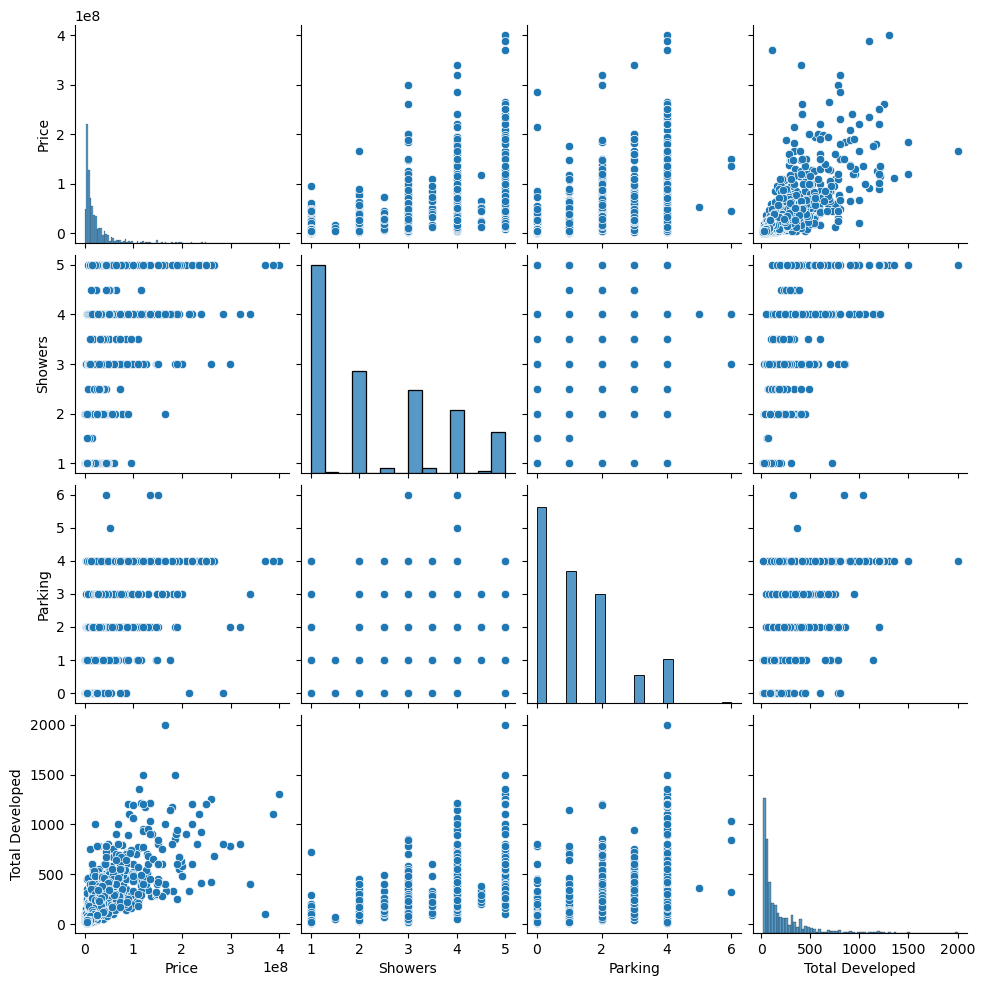

In [7]:
sns.pairplot(data = df[['Price', 'Showers', 'Parking', 'Total Developed']])

The price and total developed is positively correlated, valued at 0.58. The other features such as Bedrooms, Showers, Parking and Number of Features are a bit misleading because, even if it has a positive correlation, the scatter plot shows no trend. The only one with the trend would be Total Developed and the Price of the property which makes a lot of sense. It can be seen that the as the total developed area in square meter gets higher, the price of the properties becomes higher.

# CONCLUSIONS
- Housing Prices are **prone to outliers** mainly due to **incorrect pricing from human error** and **unfair sellers**
- The property listings is not balanced in terms of their geographical locations. Most properties can be found within Luzon as island, NCR as Region, and the difference to all the other islands and regions was big. 
- By separating condos and houses into clusters, we can help a client in deciding what property to buy by providing them the clusters that are based on how good and how affordable these properties are.